In [1]:
!pip install netron

In [10]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import netron
from tensorflow.keras.callbacks import EarlyStopping


In [5]:
df_train = pd.read_csv('train_df.csv')
df_test = pd.read_csv('test_df.csv')

train = df_train["value"].values
test = df_test["value"].values

In [ ]:
def create_sequences(data, sequence_length=24, prediction_offset=24):
    X, y = [], []
    for i in range(len(data) - sequence_length - prediction_offset):
        X.append(data[i:i + sequence_length])  # Sekwencja wejściowa
        y.append(data[i + sequence_length + prediction_offset - 1])  # Wartość docelowa 24 godziny później
    return np.array(X), np.array(y)

# Przygotowanie danych wejściowych i wyjściowych
sequence_length = 24
prediction_offset = 24
X_train, y_train = create_sequences(train, sequence_length, prediction_offset)
X_test, y_test = create_sequences(test, sequence_length, prediction_offset)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (11605, 24), y_train shape: (11605,)
X_test shape: (2884, 24), y_test shape: (2884,)


In [18]:
# Przygotowanie modelu LSTM
model = Sequential([
    LSTM(24, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),  # Pierwsza warstwa LSTM z większą liczbą jednostek
    LSTM(5, activation='relu'),  # Druga warstwa LSTM z większą liczbą jednostek
    Dense(1)  # Warstwa wyjściowa
])

# Ustawienie dużego learning rate
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.072,    # 72 / 1000
    beta_1=0.211,           # 211 / 1000
    beta_2=0.260,           # 260 / 1000
    epsilon=1e-6            # np. 300 jako epsilon * 1e-6
)
# Kompilacja modelu
model.compile(optimizer=optimizer, loss='mse')

# Wyświetlenie podsumowania modelu
model.summary()

c:\Users\micha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 24, 24)         │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 5)              │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,102 (12.12 KB)

 Trainable params: 3,102 (12.12 KB)

 Non-trainable params: 0 (0.00 B)

## Dla Funkcji aktywacji RElu

In [23]:
# Trenowanie modelu
# Dodanie metryki MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



early_stopping = EarlyStopping(
    monitor='val_loss',  # lub 'loss' jeśli nie masz walidacji
    patience=10,
    restore_best_weights=True
)

# Trenowanie modelu
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2)

#Ustawiono max iter na i early stoppning na 10 i optymalizator tak jak w literaturze

# Ocena modelu na danych testowych
loss = model.evaluate(X_test, y_test)
print(f"Loss on test data: {loss}")

# Predykcja na danych testowych
y_pred = model.predict(X_test)

# Obliczenie MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE on test data: {mape}%")


Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 80899824.0000 - val_loss: 8878404.0000
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 72534584.0000 - val_loss: 171551824.0000
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 71446960.0000 - val_loss: 29134992.0000
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 71954784.0000 - val_loss: 46833044.0000
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 68861552.0000 - val_loss: 55575656.0000
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 70282648.0000 - val_loss: 28877220.0000
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 65427928.0000 - val_loss: 55790392.0000
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 66716272.0000 - val_loss: 73694240.0000
Epoch 9/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 68593408.0000 - val_loss: 84240432.0000
Epoch 10/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 64752868.0000 - val_loss: 256

In [ ]:
# model.save('lstm_model_relu.keras')
# model = tf.keras.models.load_model('lstm_model.keras')

In [45]:
netron.start("lstm_model.keras")

Serving 'lstm_model.keras' at http://localhost:8080


('localhost', 8080)

In [20]:
y_pred.shape

(2884, 1)

In [21]:
y_test.shape

(2884,)

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = model.predict(X_test)
# Obliczanie mRSE
mse = mean_squared_error(y_test, y_pred)
mean_y_test = np.mean(y_test)
mRSE = np.sqrt(mse) / mean_y_test

# Obliczanie MAE
MAE = mean_absolute_error(y_test, y_pred)

# Obliczanie MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE = mean_absolute_percentage_error(y_test, y_pred)

print(f"mRSE: {mRSE}")
print(f"MAE: {MAE}")
print(f"MAPE: {MAPE}%")

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mRSE: 0.16052867546580335
MAE: 2702.1599403714463
MAPE: 14.126158062888777%


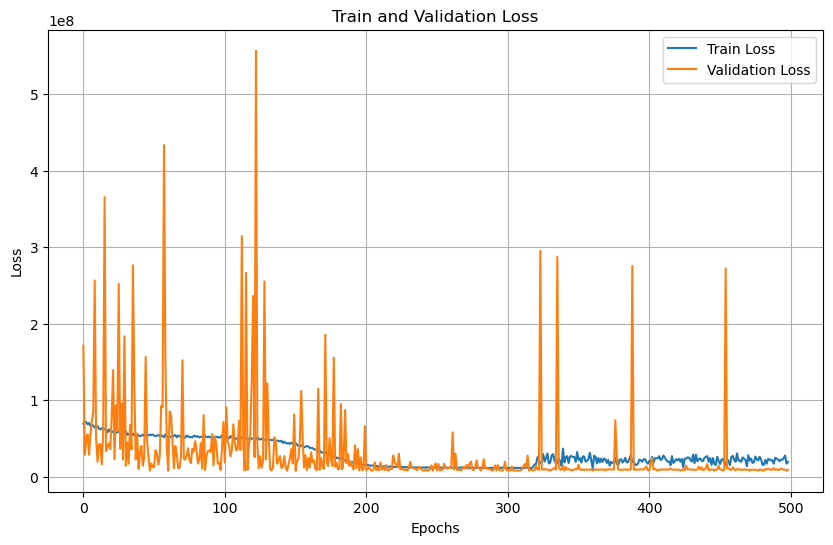

In [27]:
import matplotlib.pyplot as plt

# Wyciągnięcie danych z historii trenowania
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Dla Funkcji aktywacji tanh

In [ ]:
# Przygotowanie modelu LSTM
model = Sequential([
    LSTM(24, activation='tanh', return_sequences=True, input_shape=(sequence_length, 1)),  # Pierwsza warstwa LSTM z większą liczbą jednostek
    LSTM(5, activation='tanh'),  # Druga warstwa LSTM z większą liczbą jednostek
    Dense(1)  # Warstwa wyjściowa
])

# Ustawienie dużego learning rate
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.072,    # 72 / 1000
    beta_1=0.211,           # 211 / 1000
    beta_2=0.260,           # 260 / 1000
    epsilon=1e-6            # np. 300 jako epsilon * 1e-6
)
# Kompilacja modelu
model.compile(optimizer=optimizer, loss='mse')

# Wyświetlenie podsumowania modelu
model.summary()

c:\Users\micha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 24, 24)         │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 24, 5)          │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24, 1)          │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,102 (12.12 KB)

 Trainable params: 3,102 (12.12 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Trenowanie modelu
# Dodanie metryki MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



early_stopping = EarlyStopping(
    monitor='val_loss',  # lub 'loss' jeśli nie masz walidacji
    patience=10,
    restore_best_weights=True
)

# Trenowanie modelu
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2)

#Ustawiono max iter na i early stoppning na 10 i optymalizator tak jak w literaturze

# Ocena modelu na danych testowych
loss = model.evaluate(X_test, y_test)
print(f"Loss on test data: {loss}")

# Predykcja na danych testowych
y_pred = model.predict(X_test)

# Obliczenie MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE on test data: {mape}%")

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 376097920.0000 - val_loss: 322456256.0000
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 369443424.0000 - val_loss: 318058816.0000
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 367138368.0000 - val_loss: 313692192.0000
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 358483232.0000 - val_loss: 309356480.0000
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 356309056.0000 - val_loss: 305051488.0000
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 353123680.0000 - val_loss: 300777824.0000
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 347062400.0000 - val_loss: 296535008.0000
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 343511200.0000 - val_loss: 292323456.0000
Epoch 9/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 337516160.0000 - val_loss: 288142784.0000
Epoch 10/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 332793984.0

In [30]:
model.save('lstm_model_tahn.keras')

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = model.predict(X_test)
# Obliczanie mRSE
mse = mean_squared_error(y_test, y_pred)
mean_y_test = np.mean(y_test)
mRSE = np.sqrt(mse) / mean_y_test

# Obliczanie MAE
MAE = mean_absolute_error(y_test, y_pred)

# Obliczanie MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE = mean_absolute_percentage_error(y_test, y_pred)

print(f"mRSE: {mRSE}")
print(f"MAE: {MAE}")
print(f"MAPE: {MAPE}%")

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
import matplotlib.pyplot as plt

# Wyciągnięcie danych z historii trenowania
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()